# **Demanda de la electricidad**

In [31]:
import pandas as pd
import numpy as np
# Graficos
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU,Dense
import time
import skforecast

In [3]:
url='https://raw.githubusercontent.com/Saul-Ochoa/Time-Series/main/Forecasting/Demanda%20de%20electricidad/vic_elec.csv'
df=pd.read_csv(url,sep=',')
df.head()

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


In [5]:
df['Time']=pd.to_datetime(df['Time'],format='%Y-%m-%dT%H:%M:%SZ')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Time         52608 non-null  datetime64[ns]
 1   Demand       52608 non-null  float64       
 2   Temperature  52608 non-null  float64       
 3   Date         52608 non-null  object        
 4   Holiday      52608 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(2), object(1)
memory usage: 1.7+ MB


In [7]:
# Frecuencia cada 30 minutos
df=df.set_index('Time') # indice time
df=df.asfreq('30min')
df=df.sort_index()
df.head(5)     

,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00,4048.966046,20.70,2012-01-01,True
2011-12-31 14:30:00,3877.563330,20.55,2012-01-01,True
2011-12-31 15:00:00,4036.229746,20.40,2012-01-01,True


In [8]:
# Verificar que un índice temporal está completo
# ==============================================================================
fecha_inicio = df.index.min()
fecha_fin = df.index.max()
date_range_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq=df.index.freq)
print(f"Índice completo: {(df.index == date_range_completo).all()}")
print(f"Filas con valores ausentes: {df.isnull().any(axis=1).mean()}")

Índice completo: True
Filas con valores ausentes: 0.0


In [10]:
datos=df.drop(columns='Date')
datos = (
    datos
    .resample(rule="h", closed="left", label="right")
    .agg({
        "Demand": "mean",
        "Temperature": "mean",
        "Holiday": "mean",
    })
)
datos

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0
...,...,...,...
2014-12-31 09:00:00,4069.625550,21.600,0.0
2014-12-31 10:00:00,3909.230704,20.300,0.0
2014-12-31 11:00:00,3900.600901,19.650,0.0


In [11]:
# Separación datos train-val-test
# ==============================================================================
datos = datos.loc['2012-01-01 00:00:00':'2014-12-30 23:00:00', :].copy()
fin_train = '2013-12-31 23:59:00'
fin_validacion = '2014-11-30 23:59:00'
datos_train = datos.loc[: fin_train, :].copy()
datos_val   = datos.loc[fin_train:fin_validacion, :].copy()
datos_test  = datos.loc[fin_validacion:, :].copy()

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2012-01-01 00:00:00 --- 2013-12-31 23:00:00  (n=17544)
Fechas validacion : 2014-01-01 00:00:00 --- 2014-11-30 23:00:00  (n=8016)
Fechas test       : 2014-12-01 00:00:00 --- 2014-12-30 23:00:00  (n=720)


In [12]:
datos_train

,Demand,Temperature,Holiday
Time,,,
2012-01-01 00:00:00,4329.049863,27.000,1.0
2012-01-01 01:00:00,4685.820480,29.650,1.0
2012-01-01 02:00:00,5009.466997,31.650,1.0
2012-01-01 03:00:00,5270.116328,32.675,1.0
2012-01-01 04:00:00,5487.388289,32.300,1.0
...,...,...,...
2013-12-31 19:00:00,3021.971007,16.400,1.0
2013-12-31 20:00:00,3054.708526,17.950,1.0
2013-12-31 21:00:00,3179.705315,19.700,1.0


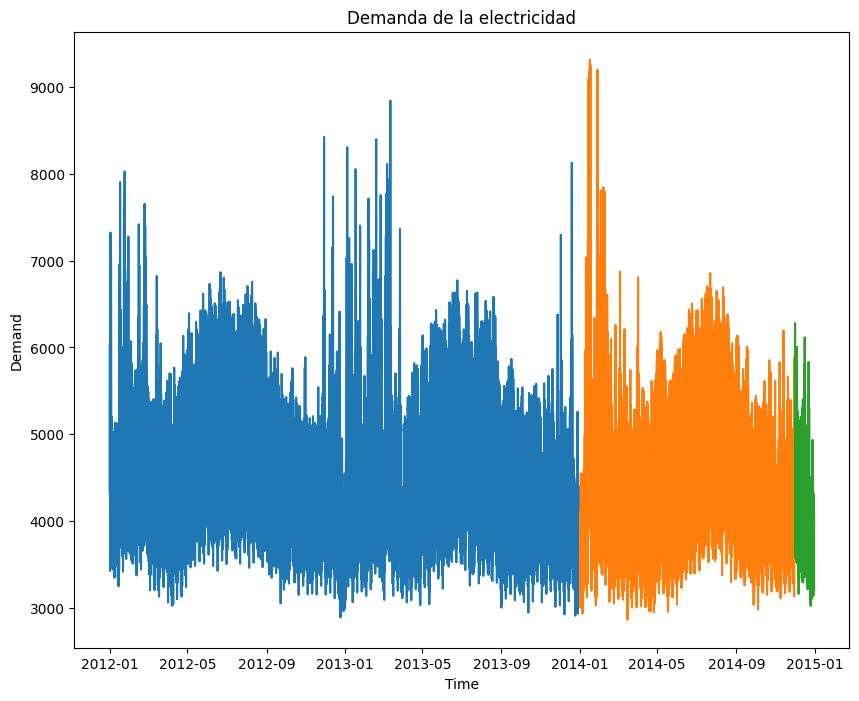

In [15]:
plt.figure(figsize=(10,8))
sns.lineplot(data=datos_train,y='Demand',x=datos_train.index)
sns.lineplot(data=datos_val,y='Demand',x=datos_val.index)
sns.lineplot(data=datos_test,y='Demand',x=datos_test.index)
plt.title('Demanda de la electricidad')
plt.show()

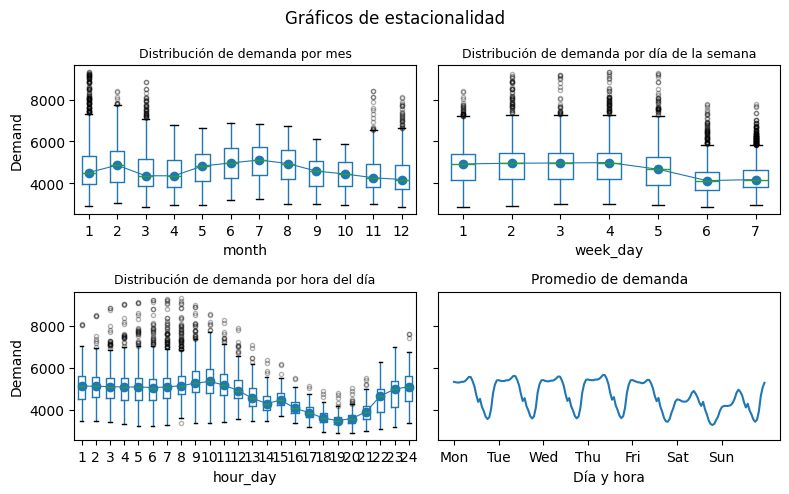

In [16]:
# Estacionalidad anual, semanal y diaria
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=False, sharey=True)
axs = axs.ravel()

# Distribusión de demanda por mes
datos['month'] = datos.index.month
datos.boxplot(column='Demand', by='month', ax=axs[0], flierprops={'markersize': 3, 'alpha': 0.3})
datos.groupby('month')['Demand'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('Demand')
axs[0].set_title('Distribución de demanda por mes', fontsize=9)

# Distribusión de demanda por día de la semana
datos['week_day'] = datos.index.day_of_week + 1
datos.boxplot(column='Demand', by='week_day', ax=axs[1], flierprops={'markersize': 3, 'alpha': 0.3})
datos.groupby('week_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('Demand')
axs[1].set_title('Distribución de demanda por día de la semana', fontsize=9)

# Distribusión de demanda por hora del día
datos['hour_day'] = datos.index.hour + 1
datos.boxplot(column='Demand', by='hour_day', ax=axs[2], flierprops={'markersize': 3, 'alpha': 0.3})
datos.groupby('hour_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('Demand')
axs[2].set_title('Distribución de demanda por hora del día', fontsize=9)

# Distribusión de demanda por día de la semana y hora del día
mean_day_hour = datos.groupby(["week_day", "hour_day"])["Demand"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title       = "Promedio de demanda",
    xticks      = [i * 24 for i in range(7)],
    xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel      = "Día y hora",
    ylabel      = "Demand"
)
axs[3].title.set_size(10)

fig.suptitle("Gráficos de estacionalidad", fontsize=12)
fig.tight_layout()

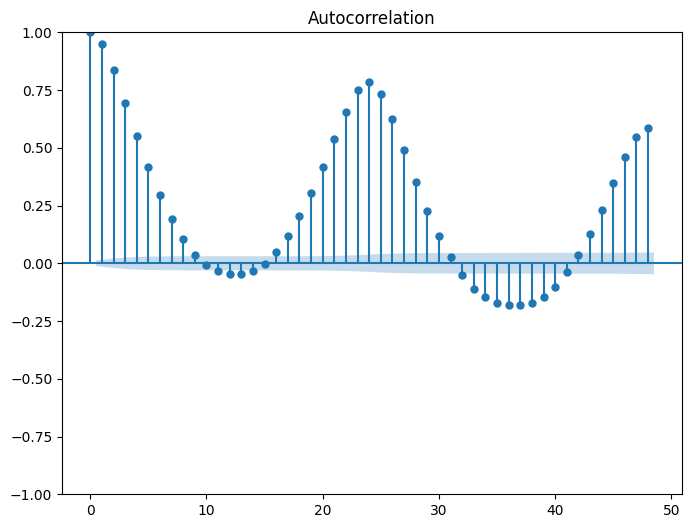

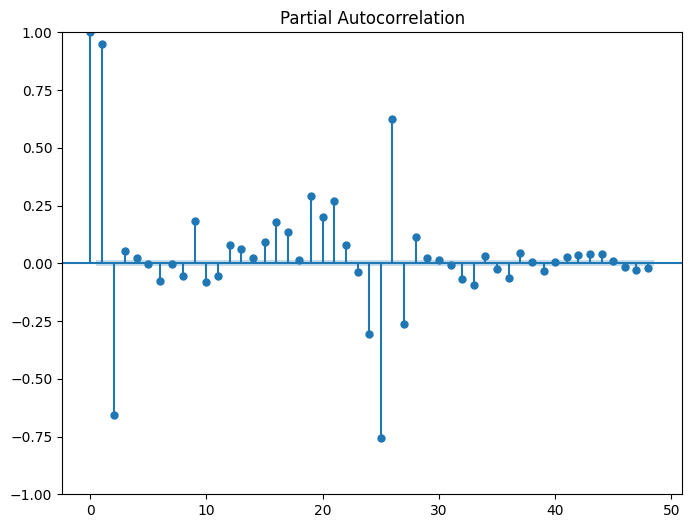

In [20]:
# Graficos ACF
fig,ax=plt.subplots(figsize=(8,6))
plot_acf(datos['Demand'],ax=ax,lags=48)
plt.show()
# Graficos PACF
fig,ax=plt.subplots(figsize=(8,6))
plot_pacf(datos['Demand'],ax=ax,lags=48)
plt.show()

In [22]:
datos.head()

,Demand,Temperature,Holiday,month,week_day,hour_day
Time,,,,,,
2012-01-01 00:00:00,4329.049863,27.000,1.0,1,7,1
2012-01-01 01:00:00,4685.820480,29.650,1.0,1,7,2
2012-01-01 02:00:00,5009.466997,31.650,1.0,1,7,3
2012-01-01 03:00:00,5270.116328,32.675,1.0,1,7,4
2012-01-01 04:00:00,5487.388289,32.300,1.0,1,7,5


In [23]:
# Normalizar los datos de 0 y 1
scaler=MinMaxScaler()
datos_train_scaled=scaler.fit_transform(datos_train[['Demand']])
datos_val_scaled = scaler.transform(datos_val[['Demand']])
datos_test_scaled = scaler.transform(datos_test[['Demand']])

In [ ]:
# Importante creación de secuencias
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 48  # Ventanas de 24 horas
X_train, y_train = create_sequences(datos_train_scaled, sequence_length)
X_val, y_val = create_sequences(datos_val_scaled, sequence_length)
X_test, y_test = create_sequences(datos_test_scaled, sequence_length)

In [25]:
print(f"Shape X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Shape X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape X_train: (17496, 48, 1), y_train: (17496, 1)
Shape X_val: (7968, 48, 1), y_val: (7968, 1)
Shape X_test: (672, 48, 1), y_test: (672, 1)


## **Modelo GRU**

In [27]:
model=Sequential([
    GRU(units=50,return_sequences=True,input_shape=(sequence_length, 1)),
    GRU(units=50,return_sequences=False),
    Dense(units=1)  
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 48, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 53s 80ms/step - loss: 0.0097 - val_loss: 0.0015
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - loss: 8.6192e-04 - val_loss: 8.6979e-04
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - loss: 7.4538e-04 - val_loss: 6.2989e-04
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - loss: 4.9675e-04 - val_loss: 4.9978e-04
Epoch 9/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 34s 62ms/step - loss: 4.5364e-04 - val_loss: 5.5850e-04
Epoch 10/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - loss: 4.1982e-04 - val_loss: 5.5561e-04
Epoch 11/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - loss: 3.9531e-04 - val

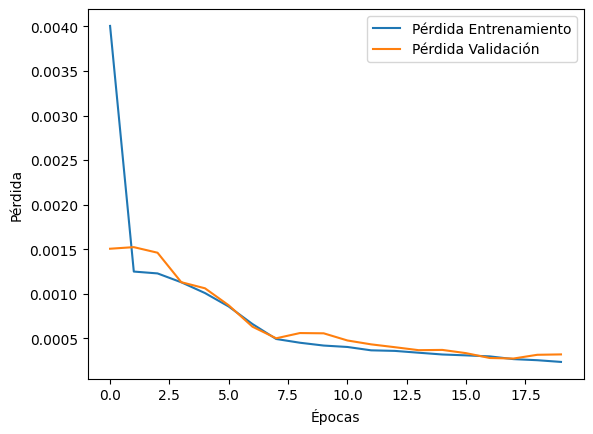

In [29]:
# Graficar la pérdida
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [30]:
# Evaluar y predecir 
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Predecir
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Escalar y_test de vuelta
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0583e-04
Test Loss: 0.0003096199652645737
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [32]:
# Metricas 
r2=r2_score(y_test_original,predictions)
print(f"R2 : {r2:.2f}")

mse=mean_squared_error(y_test_original,predictions)
print(f"Mean Squared Error (MSE) : {mse:.2f}")

mae = mean_absolute_error(y_test_original, predictions)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

R2 : 0.98
Mean Squared Error (MSE) : 10969.70
Mean Absolute Error (MAE): 79.67
Root Mean Squared Error (RMSE): 104.74


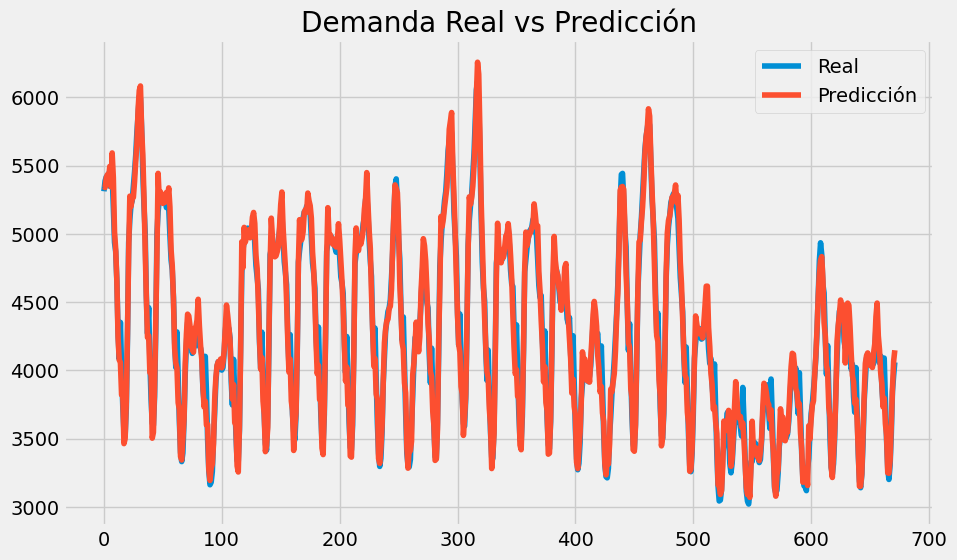

In [34]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Real')
plt.plot(predictions, label='Predicción')
plt.legend()
plt.title('Demanda Real vs Predicción')
plt.show()